### Library importing and seed setting

In [1]:
seed=1
import os
os.environ['PYTHONHASHSEED'] = str(seed)
# For working on GPUs from "TensorFlow Determinism"
os.environ["TF_DETERMINISTIC_OPS"] = str(seed)
import numpy as np
np.random.seed(seed)
import random
random.seed(seed)
import tensorflow as tf
tf.random.set_seed(seed)
kernel_initializer=tf.keras.initializers.glorot_uniform(seed=seed)
import PIL
import PIL.Image
import pathlib
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import files

In [4]:
%%capture
!pip install ipython-autotime

In [5]:
%load_ext autotime

time: 584 µs (started: 2022-12-03 22:13:49 +00:00)


In [6]:
print(tf.__version__)

2.9.2
time: 1.01 ms (started: 2022-12-03 22:13:49 +00:00)


### Data importing and preprocessing

In [7]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
time: 2.14 s (started: 2022-12-03 22:13:49 +00:00)


In [8]:
%%capture
!unzip gdrive/My\ Drive/Machine\ Learning\ Project/CatsDogs.zip 

time: 30 s (started: 2022-12-03 20:24:49 +00:00)


In [2]:
data_dir = pathlib.Path("/content/CatsDogs")
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

23404


In [ ]:
#There were corupted images in dataset, code below deleted them.
num_skipped = 0
total = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("CatsDogs", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            total += 1
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Total %d Deleted %d images" % (total, num_skipped) )

In [9]:
batch_size = 128
img_height = 150
img_width = 150 

time: 918 µs (started: 2022-12-03 22:13:52 +00:00)


In [4]:
train_ds= tf.keras.utils.image_dataset_from_directory(
  data_dir,
    color_mode="rgb",
  validation_split=0.3,
  subset="training",
  shuffle=True,
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 23404 files belonging to 2 classes.
Using 16383 files for training.


In [5]:
val_ds= tf.keras.utils.image_dataset_from_directory(
  data_dir,
    color_mode="rgb",
  validation_split=0.3,
  subset="validation",
  seed=seed,#123
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 23404 files belonging to 2 classes.
Using 7021 files for validation.


In [6]:
test_ds = val_ds.take(round(len(val_ds)*0.3))
val_ds = val_ds.skip(round(len(val_ds)*0.3))
print(val_ds.cardinality())
print(test_ds.cardinality())

tf.Tensor(39, shape=(), dtype=int64)
tf.Tensor(16, shape=(), dtype=int64)


In [15]:
dataset_unbatched = tuple(test_ds.unbatch())
labels = []
for (image,label) in dataset_unbatched:
    labels.append(label.numpy())
labels = pd.Series(labels)
count = labels.value_counts()
print(count)

1    1039
0    1009
dtype: int64
time: 3.92 s (started: 2022-12-03 22:14:59 +00:00)


In [14]:
dataset_unbatched1 = tuple(val_ds.unbatch())
labels = []
for (image,label) in dataset_unbatched1:
    labels.append(label.numpy())
labels = pd.Series(labels)
count = labels.value_counts()
print(count)

0    2506
1    2467
dtype: int64
time: 9.54 s (started: 2022-12-03 22:14:46 +00:00)


In [13]:
dataset_unbatched0 = tuple(train_ds.unbatch())
labels = []
for (image,label) in dataset_unbatched0:
    labels.append(label.numpy())
labels = pd.Series(labels)
count = labels.value_counts()
print(count)

0    8214
1    8169
dtype: int64
time: 38.5 s (started: 2022-12-03 22:13:59 +00:00)


In [7]:
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.RandomRotation((-0.20, 0.20),seed=1),
    tf.keras.layers.RandomZoom((-0.30,0.30),seed=1), 
  ]
)

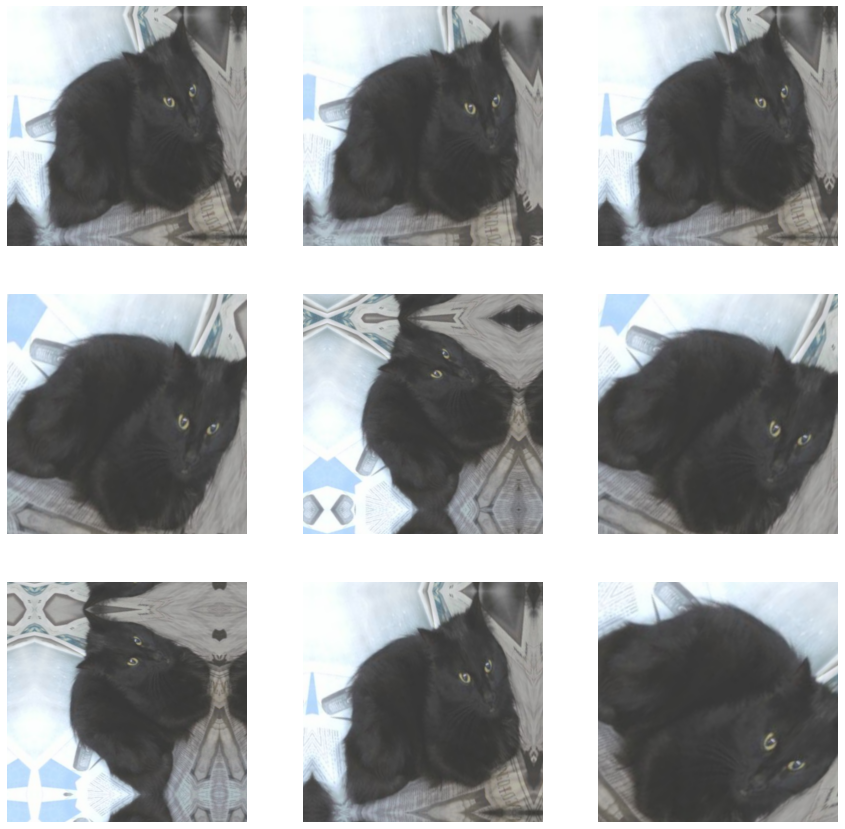

In [9]:
plt.figure(figsize=(15, 15))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [16]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
#test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

time: 5.56 ms (started: 2022-12-03 20:25:25 +00:00)


### Zero model - Just Neural Deep NN

In [17]:
model_0 = tf.keras.Sequential([
data_augmentation,
tf.keras.layers.Rescaling(1./255, input_shape=(img_height, img_width,3)),
#Neural Network
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(64, activation="relu",kernel_initializer=tf.keras.initializers.glorot_uniform(seed=1)),  
tf.keras.layers.Dense(128, activation="relu",kernel_initializer=tf.keras.initializers.glorot_uniform(seed=1)),
tf.keras.layers.Dense(256, activation="relu",kernel_initializer=tf.keras.initializers.glorot_uniform(seed=1)),
tf.keras.layers.Dense(512, activation="relu",kernel_initializer=tf.keras.initializers.glorot_uniform(seed=1)),
tf.keras.layers.Dense(256, activation="relu",kernel_initializer=tf.keras.initializers.glorot_uniform(seed=1)),
tf.keras.layers.Dense(128, activation="relu",kernel_initializer=tf.keras.initializers.glorot_uniform(seed=1)),
tf.keras.layers.Dense(64, activation="relu",kernel_initializer=tf.keras.initializers.glorot_uniform(seed=1)),
tf.keras.layers.Dense(1, activation='sigmoid',kernel_initializer=tf.keras.initializers.glorot_uniform(seed=1)), 
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0006) 

# 2. Metric
metric = tf.keras.metrics.BinaryAccuracy()

# 3. Loss Function
loss_function = tf.keras.losses.BinaryCrossentropy()

# compiling the neural network
model_0.compile(optimizer=optimizer, loss=loss_function, metrics=metric)

time: 29.6 ms (started: 2022-12-03 20:26:03 +00:00)


In [18]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3,mode="min")
# This callback will stop the training when there is no improvement in
# the val_loss for three consecutive epochs.
epochs = 20
history_0=model_0.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
    verbose=1,
    callbacks=[callback]
)

Epoch 1/20
128/128 [==============================] - 31s 210ms/step - loss: 0.7155 - binary_accuracy: 0.5240 - val_loss: 0.6770 - val_binary_accuracy: 0.5827
Epoch 2/20
128/128 [==============================] - 3s 23ms/step - loss: 0.6826 - binary_accuracy: 0.5601 - val_loss: 0.6840 - val_binary_accuracy: 0.5059
Epoch 3/20
128/128 [==============================] - 3s 24ms/step - loss: 0.6785 - binary_accuracy: 0.5713 - val_loss: 0.6697 - val_binary_accuracy: 0.5944
Epoch 4/20
128/128 [==============================] - 3s 23ms/step - loss: 0.6735 - binary_accuracy: 0.5777 - val_loss: 0.6615 - val_binary_accuracy: 0.5956
Epoch 5/20
128/128 [==============================] - 3s 25ms/step - loss: 0.6680 - binary_accuracy: 0.5871 - val_loss: 0.6803 - val_binary_accuracy: 0.5158
Epoch 6/20
128/128 [==============================] - 3s 22ms/step - loss: 0.6700 - binary_accuracy: 0.5814 - val_loss: 0.6650 - val_binary_accuracy: 0.5988
Epoch 7/20
128/128 [==============================] - 3s

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

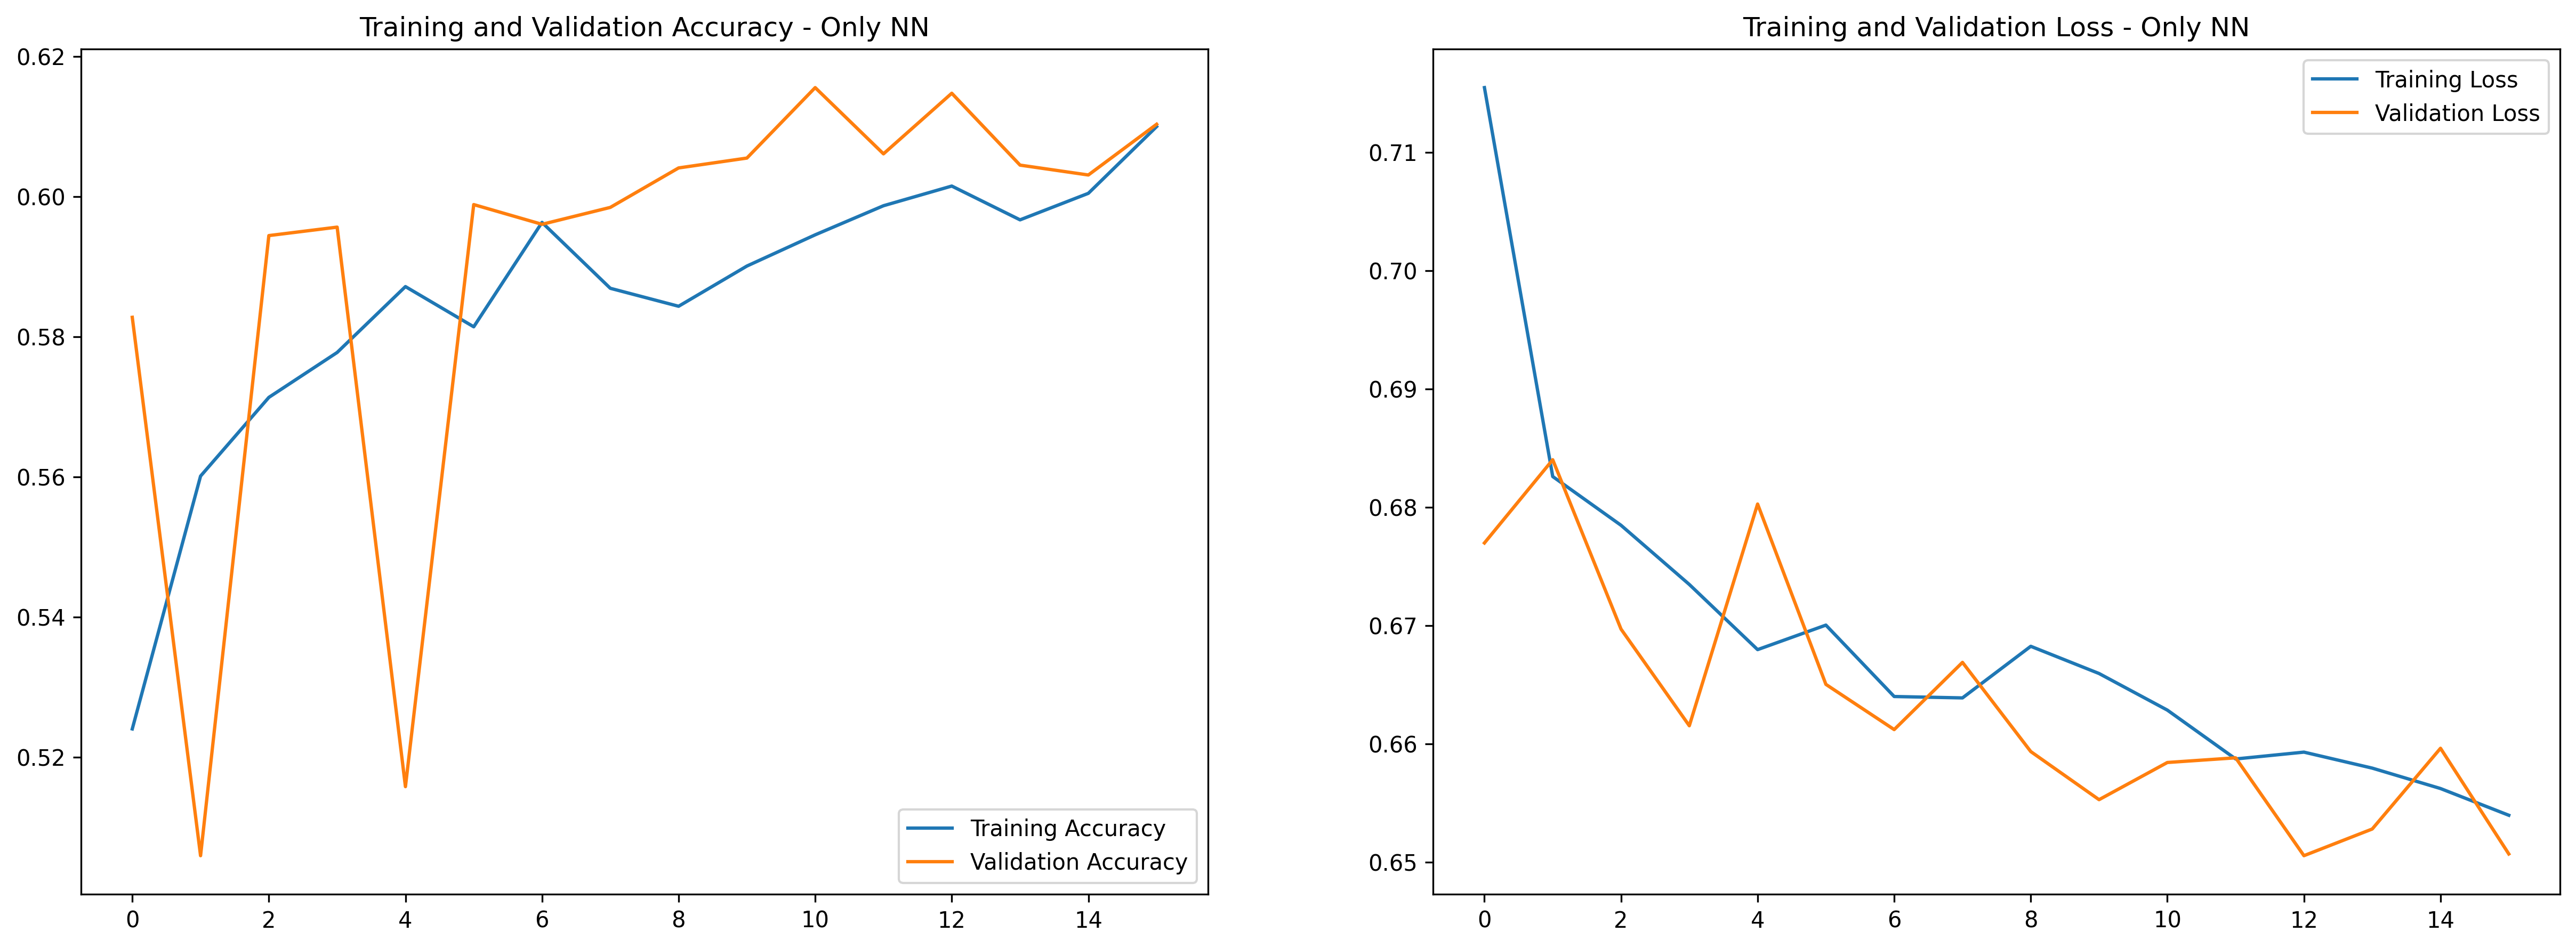

time: 1.18 s (started: 2022-12-03 20:45:56 +00:00)


In [36]:
acc = history_0.history['binary_accuracy']
val_acc = history_0.history['val_binary_accuracy']

loss = history_0.history['loss']
val_loss = history_0.history['val_loss']

epochs_range = range(16)

plt.figure(figsize=(20, 7),dpi= 300)
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy - Only NN')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss - Only NN')
#plt.show()
plt.savefig("model_0.pdf")
files.download("model_0.pdf") 

In [23]:
model_0.evaluate(train_ds)

128/128 [==============================] - 2s 16ms/step - loss: 0.6432 - binary_accuracy: 0.6175


[0.6432231664657593, 0.617469310760498]

time: 2.03 s (started: 2022-12-03 20:30:57 +00:00)


In [24]:
model_0.evaluate(val_ds)

39/39 [==============================] - 1s 16ms/step - loss: 0.6507 - binary_accuracy: 0.6103


[0.6506863236427307, 0.6102955937385559]

time: 628 ms (started: 2022-12-03 20:30:59 +00:00)


### First model - Simplest

In [27]:
model_1 = tf.keras.Sequential([
data_augmentation,
tf.keras.layers.Rescaling(1./255, input_shape=(img_height, img_width,3)),

tf.keras.layers.Conv2D(32, (3, 3), strides = 1,padding="same", activation='relu',kernel_initializer=tf.keras.initializers.glorot_uniform(seed=1)),
tf.keras.layers.MaxPool2D(pool_size=(2,2)),

#Neural Network
tf.keras.layers.Flatten(), 
tf.keras.layers.Dense(256, activation="relu",name="dense_1",kernel_initializer=tf.keras.initializers.glorot_uniform(seed=1)),
tf.keras.layers.Dropout(0.1,seed=1),
tf.keras.layers.Dense(1, activation='sigmoid', name="dense_2",kernel_initializer=tf.keras.initializers.glorot_uniform(seed=1)), 
])
# 1. Optimiser
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0006)

# 2. Metric
metric = tf.keras.metrics.BinaryAccuracy()

# 3. Loss Function
loss_function = tf.keras.losses.BinaryCrossentropy() 

# compiling the neural network
model_1.compile(optimizer=optimizer, loss=loss_function, metrics=metric)

time: 20.1 ms (started: 2022-12-03 20:34:07 +00:00)


In [28]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3,mode="min")
# This callback will stop the training when there is no improvement in
# the val_loss for three consecutive epochs.
epochs = 20
history1=model_1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
    verbose=1,
    callbacks=[callback]
)

Epoch 1/20
128/128 [==============================] - 17s 80ms/step - loss: 1.5527 - binary_accuracy: 0.5078 - val_loss: 0.6929 - val_binary_accuracy: 0.5063
Epoch 2/20
128/128 [==============================] - 10s 78ms/step - loss: 0.6915 - binary_accuracy: 0.5137 - val_loss: 0.6815 - val_binary_accuracy: 0.5836
Epoch 3/20
128/128 [==============================] - 9s 72ms/step - loss: 0.6763 - binary_accuracy: 0.5760 - val_loss: 0.6276 - val_binary_accuracy: 0.6427
Epoch 4/20
128/128 [==============================] - 9s 72ms/step - loss: 0.6382 - binary_accuracy: 0.6172 - val_loss: 0.6275 - val_binary_accuracy: 0.6435
Epoch 5/20
128/128 [==============================] - 9s 73ms/step - loss: 0.6264 - binary_accuracy: 0.6338 - val_loss: 0.6175 - val_binary_accuracy: 0.6547
Epoch 6/20
128/128 [==============================] - 9s 73ms/step - loss: 0.6143 - binary_accuracy: 0.6447 - val_loss: 0.6142 - val_binary_accuracy: 0.6473
Epoch 7/20
128/128 [==============================] - 9s

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

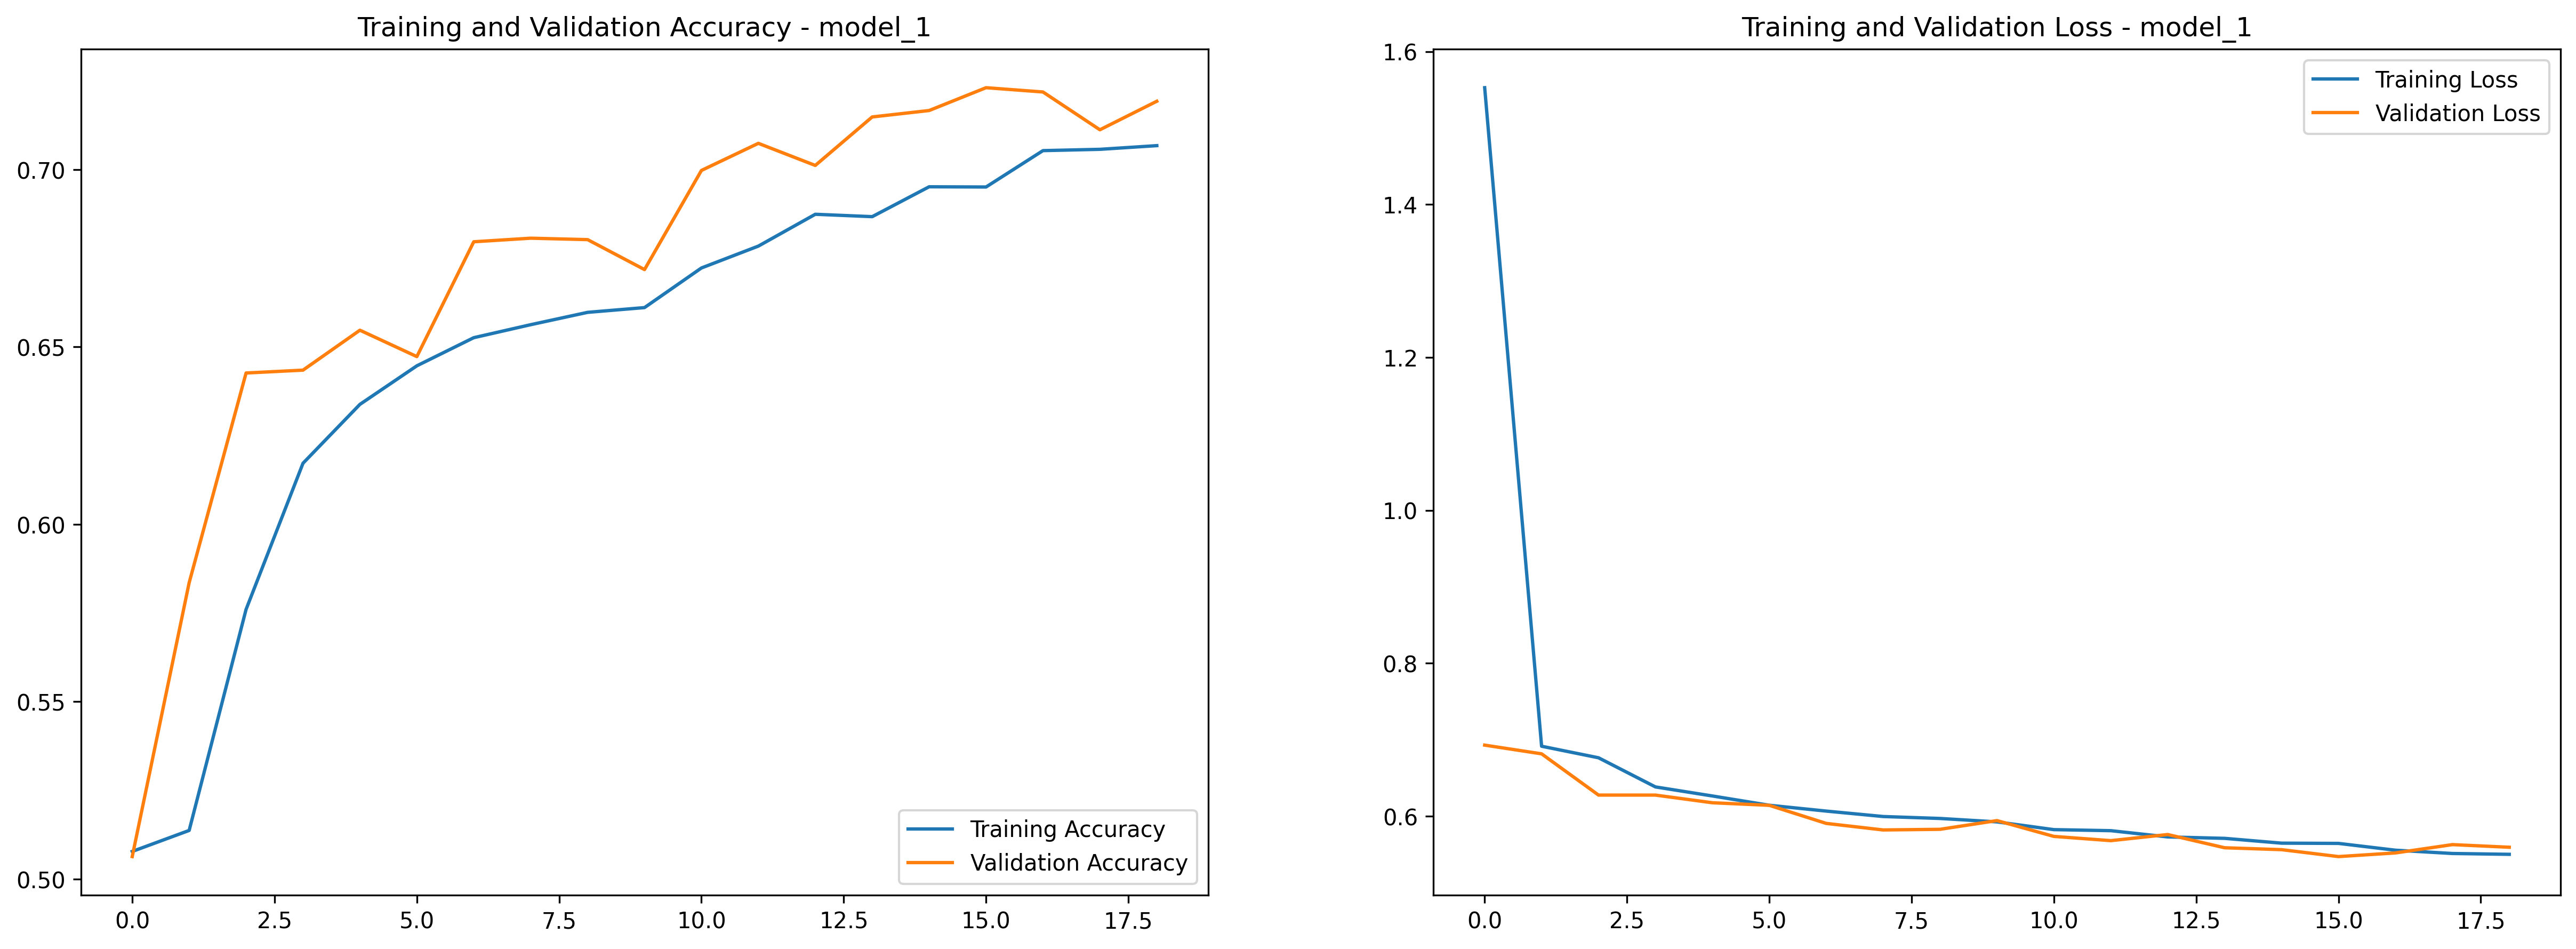

time: 1.75 s (started: 2022-12-03 20:46:52 +00:00)


In [37]:
acc = history1.history['binary_accuracy']
val_acc = history1.history['val_binary_accuracy']

loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs_range = range(19)

plt.figure(figsize=(20, 7),dpi=300)
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy - model_1')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss - model_1')
plt.savefig("model_1.pdf")
files.download("model_1.pdf") 

In [33]:
model_1.evaluate(train_ds)

128/128 [==============================] - 4s 29ms/step - loss: 0.5408 - binary_accuracy: 0.7320


[0.5408100485801697, 0.7320393323898315]

time: 3.77 s (started: 2022-12-03 20:44:27 +00:00)


In [34]:
model_1.evaluate(val_ds)

39/39 [==============================] - 1s 29ms/step - loss: 0.5593 - binary_accuracy: 0.7193


[0.5593391060829163, 0.7192841172218323]

time: 1.14 s (started: 2022-12-03 20:44:31 +00:00)


In [ ]:
#pip install visualkeras

In [ ]:
import visualkeras
#visualkeras.layered_view(model_1, legend=True, spacing=10)

### Second Model

In [31]:
model_2 = tf.keras.Sequential([
data_augmentation,
tf.keras.layers.Rescaling(1./255, input_shape=(img_height, img_width,3)),

tf.keras.layers.Conv2D(32, (3, 3), strides = 1,padding="same", activation='relu',kernel_initializer=tf.keras.initializers.glorot_uniform(seed=1)),
tf.keras.layers.MaxPool2D(pool_size=(2,2)),

tf.keras.layers.Conv2D(64, (3, 3), padding="same",strides = 1, activation='relu',kernel_initializer=tf.keras.initializers.glorot_uniform(seed=1)),
tf.keras.layers.MaxPool2D(pool_size=(2,2)),

#Neural Network
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(256, activation="relu", name="dense_1",kernel_initializer=tf.keras.initializers.glorot_uniform(seed=1)),  
tf.keras.layers.Dropout(0.1,seed=1), 
tf.keras.layers.Dense(256, activation="relu", name="dense_added",kernel_initializer=tf.keras.initializers.glorot_uniform(seed=1)),
tf.keras.layers.Dropout(0.1,seed=1),
tf.keras.layers.Dense(1, activation='sigmoid', name="dense_2",kernel_initializer=tf.keras.initializers.glorot_uniform(seed=1)), 
])
# 1. Optimiser
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0006) 

# 2. Metric
metric = tf.keras.metrics.BinaryAccuracy()

# 3. Loss Function
loss_function = tf.keras.losses.BinaryCrossentropy() 

# compiling the neural network
model_2.compile(optimizer=optimizer, loss=loss_function, metrics=metric)

time: 23.1 ms (started: 2022-12-03 20:39:28 +00:00)


In [32]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3,mode="min")
# This callback will stop the training when there is no improvement in
# the val_loss for three consecutive epochs.
epochs = 20
history_2=model_2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
    verbose=1,
    callbacks=[callback]
)

Epoch 1/20
128/128 [==============================] - 17s 123ms/step - loss: 0.6969 - binary_accuracy: 0.5721 - val_loss: 0.6029 - val_binary_accuracy: 0.6754
Epoch 2/20
128/128 [==============================] - 14s 111ms/step - loss: 0.5948 - binary_accuracy: 0.6811 - val_loss: 0.5672 - val_binary_accuracy: 0.7060
Epoch 3/20
128/128 [==============================] - 14s 111ms/step - loss: 0.5748 - binary_accuracy: 0.6993 - val_loss: 0.5318 - val_binary_accuracy: 0.7368
Epoch 4/20
128/128 [==============================] - 14s 111ms/step - loss: 0.5454 - binary_accuracy: 0.7189 - val_loss: 0.5221 - val_binary_accuracy: 0.7466
Epoch 5/20
128/128 [==============================] - 14s 112ms/step - loss: 0.5291 - binary_accuracy: 0.7351 - val_loss: 0.5041 - val_binary_accuracy: 0.7488
Epoch 6/20
128/128 [==============================] - 14s 111ms/step - loss: 0.5149 - binary_accuracy: 0.7417 - val_loss: 0.5085 - val_binary_accuracy: 0.7490
Epoch 7/20
128/128 [==========================

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

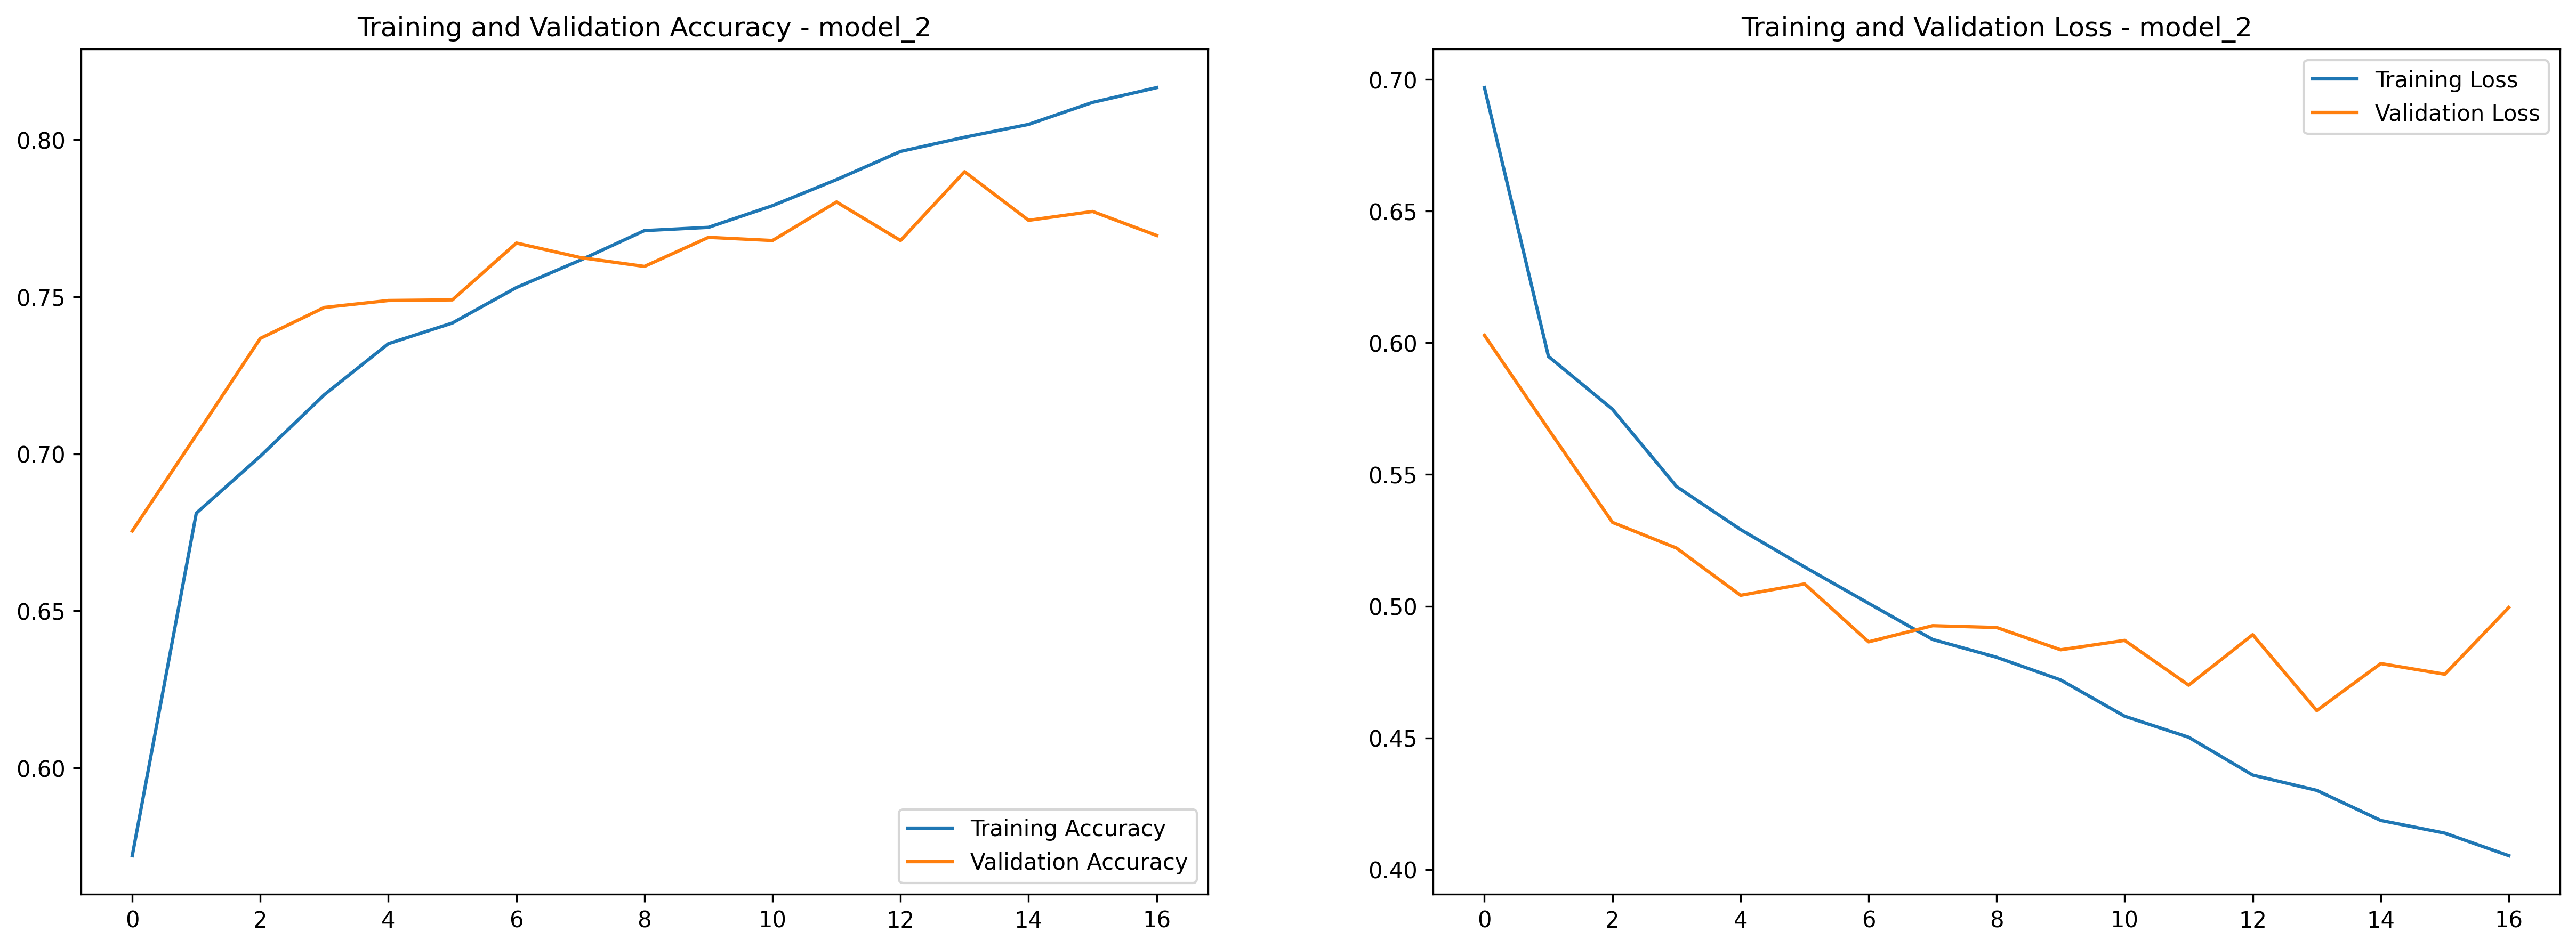

time: 1.46 s (started: 2022-12-03 20:47:25 +00:00)


In [38]:
acc = history_2.history['binary_accuracy']
val_acc = history_2.history['val_binary_accuracy']

loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

epochs_range = range(17)

plt.figure(figsize=(20, 7),dpi=300)
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy - model_2')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss - model_2')
plt.savefig("model_2.pdf")
files.download("model_2.pdf") 

### Third model ( this arhitecture was used for hyperparameters tuning and cross validation)

In [43]:
model_3 = tf.keras.Sequential([
data_augmentation,
tf.keras.layers.Rescaling(1./255, input_shape=(img_height, img_width,3)),

tf.keras.layers.Conv2D(32, (3, 3), strides = 1,padding="same", activation='relu',kernel_initializer=tf.keras.initializers.glorot_uniform(seed=1)),
tf.keras.layers.MaxPool2D(pool_size=(2,2)),


tf.keras.layers.Conv2D(64, (3, 3), strides = 1,padding="same", activation='relu',kernel_initializer=tf.keras.initializers.glorot_uniform(seed=1)),
tf.keras.layers.MaxPool2D(pool_size=(2,2)),

tf.keras.layers.Conv2D(64, (3, 3), strides = 1, activation='relu',kernel_initializer=tf.keras.initializers.glorot_uniform(seed=1)),
tf.keras.layers.MaxPool2D(pool_size=(2,2)),

tf.keras.layers.Conv2D(128, (3, 3), strides = 1,padding="same", activation='relu',kernel_initializer=tf.keras.initializers.glorot_uniform(seed=1)),
tf.keras.layers.MaxPool2D(pool_size=(2,2)),

tf.keras.layers.Conv2D(128, (3, 3), strides = 1,padding="same", activation='relu',kernel_initializer=tf.keras.initializers.glorot_uniform(seed=1)),
tf.keras.layers.MaxPool2D(pool_size=(2,2)),

    
#Neural Network
tf.keras.layers.Flatten(), 
tf.keras.layers.Dense(256, activation="relu",kernel_initializer=tf.keras.initializers.glorot_uniform(seed=1)),
tf.keras.layers.Dropout(0.1,seed=1),
tf.keras.layers.Dense(256, activation="relu",kernel_initializer=tf.keras.initializers.glorot_uniform(seed=1)),
tf.keras.layers.Dropout(0.1,seed=1),
tf.keras.layers.Dense(256, activation="relu",kernel_initializer=tf.keras.initializers.glorot_uniform(seed=1)),
tf.keras.layers.Dropout(0.1,seed=1),
tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer=tf.keras.initializers.glorot_uniform(seed=1)), 
])
# 1. Optimiser
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0006) 

# 2. Metric
metric = tf.keras.metrics.BinaryAccuracy()

# 3. Loss Function
loss_function = tf.keras.losses.BinaryCrossentropy() 

# compiling the neural network
model_3.compile(optimizer=optimizer, loss=loss_function, metrics=metric)

time: 27.6 ms (started: 2022-12-03 20:52:56 +00:00)


In [44]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3,mode='min')
# This callback will stop the training when there is no improvement in
# the val_loss for three consecutive epochs.
epochs = 20
history_3=model_3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
    verbose=1,
    callbacks=[callback]
)

Epoch 1/20
128/128 [==============================] - 19s 134ms/step - loss: 0.6843 - binary_accuracy: 0.5473 - val_loss: 0.6560 - val_binary_accuracy: 0.5922
Epoch 2/20
128/128 [==============================] - 16s 125ms/step - loss: 0.6116 - binary_accuracy: 0.6585 - val_loss: 0.5753 - val_binary_accuracy: 0.7042
Epoch 3/20
128/128 [==============================] - 17s 133ms/step - loss: 0.5604 - binary_accuracy: 0.7137 - val_loss: 0.5260 - val_binary_accuracy: 0.7372
Epoch 4/20
128/128 [==============================] - 16s 128ms/step - loss: 0.5252 - binary_accuracy: 0.7389 - val_loss: 0.4970 - val_binary_accuracy: 0.7583
Epoch 5/20
128/128 [==============================] - 17s 130ms/step - loss: 0.4963 - binary_accuracy: 0.7553 - val_loss: 0.4606 - val_binary_accuracy: 0.7838
Epoch 6/20
128/128 [==============================] - 17s 132ms/step - loss: 0.4734 - binary_accuracy: 0.7747 - val_loss: 0.4471 - val_binary_accuracy: 0.7909
Epoch 7/20
128/128 [==========================

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

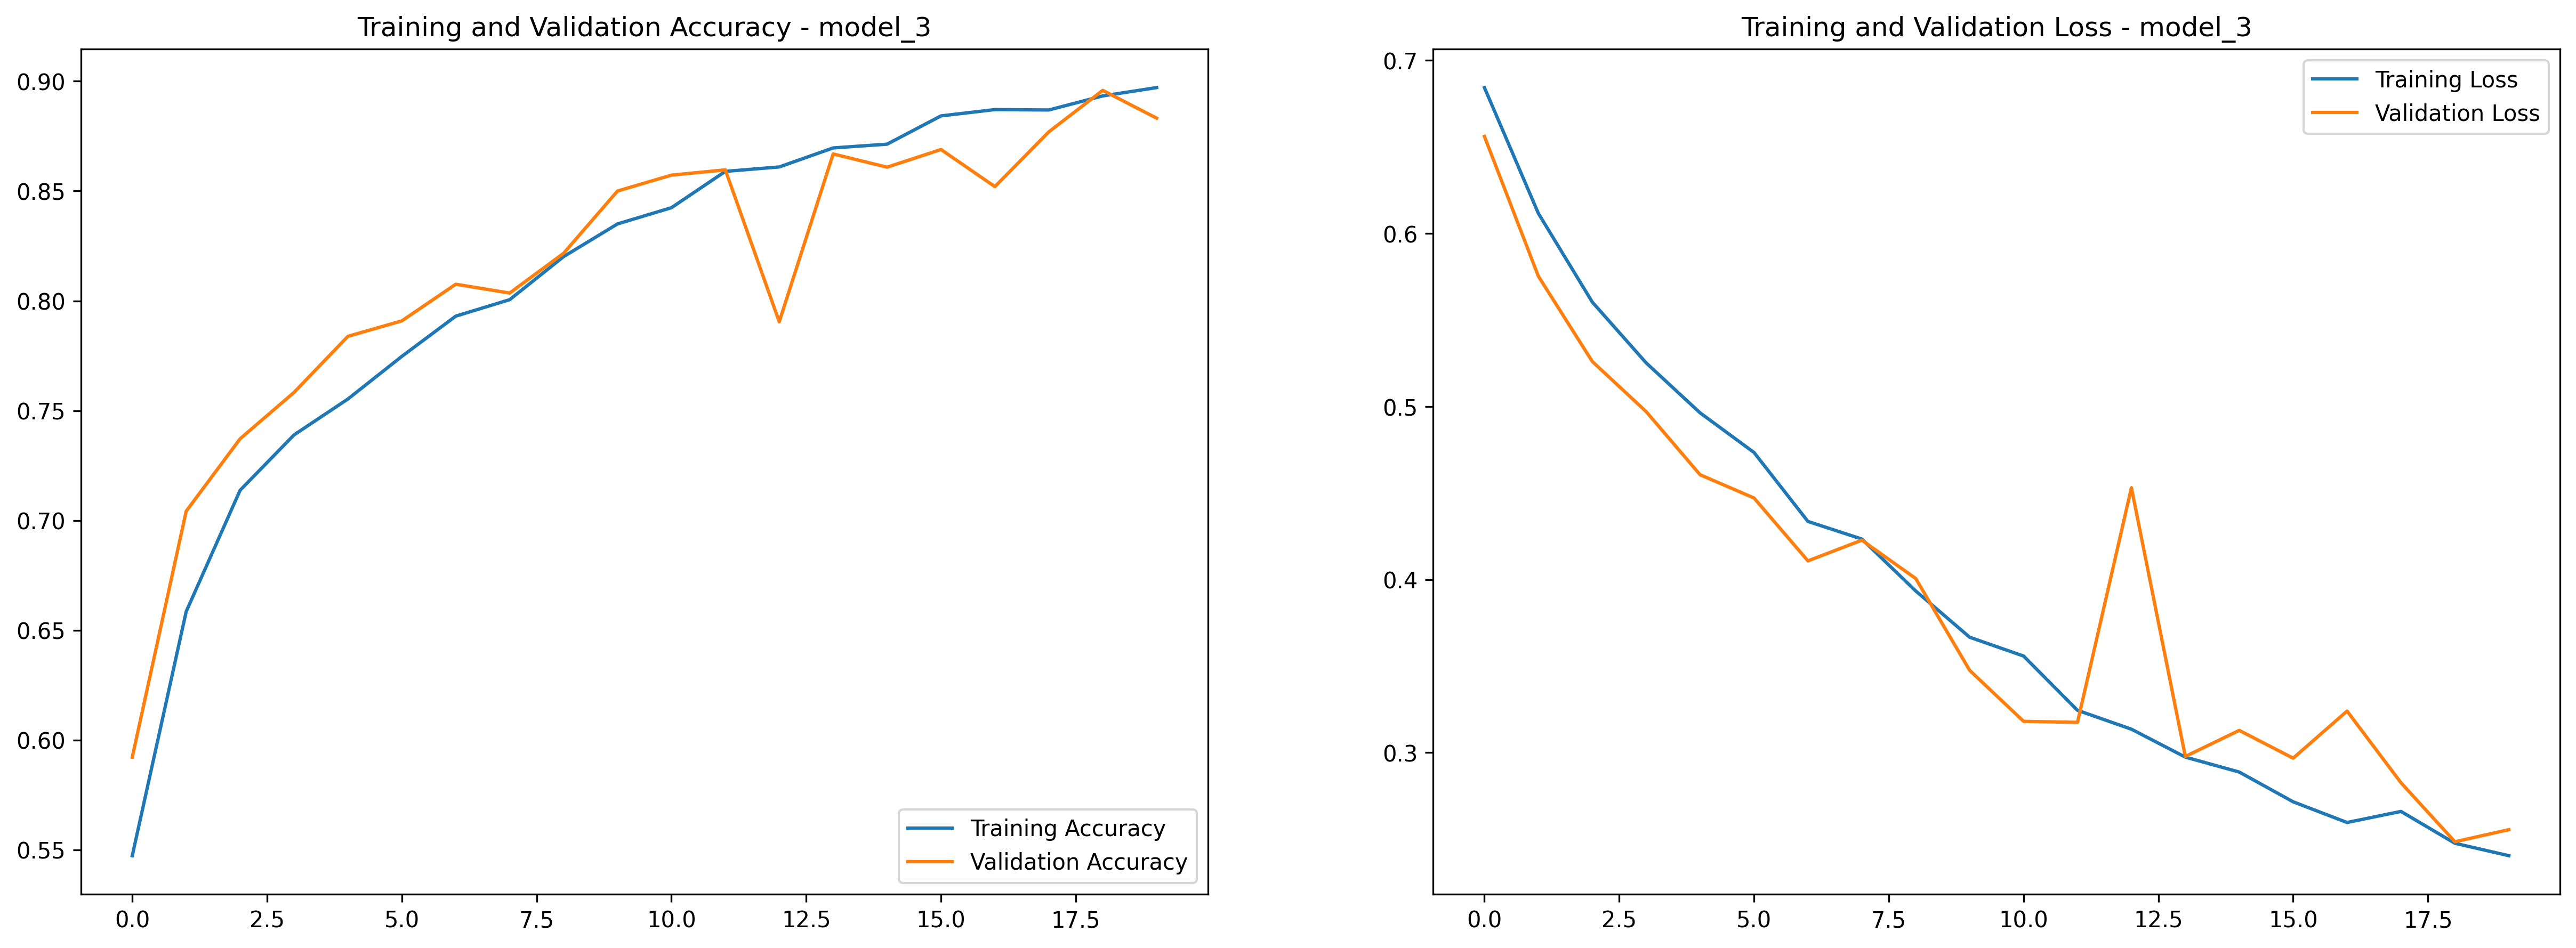

time: 1.09 s (started: 2022-12-03 21:01:11 +00:00)


In [49]:
acc = history_3.history['binary_accuracy']
val_acc = history_3.history['val_binary_accuracy']

loss = history_3.history['loss']
val_loss = history_3.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(20, 7),dpi=300)
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy - model_3')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss - model_3')
plt.savefig("model_3.pdf")
files.download("model_3.pdf") 

In [47]:
model_3.evaluate(train_ds)

128/128 [==============================] - 6s 50ms/step - loss: 0.2125 - binary_accuracy: 0.9082


[0.2125265747308731, 0.9081975221633911]

time: 6.46 s (started: 2022-12-03 21:00:20 +00:00)


In [48]:
model_3.evaluate(val_ds)

39/39 [==============================] - 2s 50ms/step - loss: 0.2555 - binary_accuracy: 0.8832


[0.25549280643463135, 0.8831691145896912]

time: 1.96 s (started: 2022-12-03 21:00:27 +00:00)


In [ ]:
#!pip install visualkeras
import visualkeras
visualkeras.layered_view(model_3, legend=True, spacing=50)

### Hyperparameters tuning


In [ ]:
from tensorboard.plugins.hparams import api as hp
from tensorflow.keras.callbacks import TensorBoard

time: 10.7 ms (started: 2022-12-03 15:01:31 +00:00)


In [ ]:
%load_ext tensorboard

time: 5.92 ms (started: 2022-12-03 15:01:31 +00:00)


In [ ]:
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([128, 256, 512])) 
HP_DROPOUT = hp.HParam("dropout_rate",hp.Discrete([10,20,30]))
HP_LEARNING_RATE=hp.HParam("learning_rate",hp.Discrete([6,8,10]))

METRIC_ACCURACY = 'accuracy'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_NUM_UNITS, HP_DROPOUT, HP_LEARNING_RATE],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
  )

time: 11.4 ms (started: 2022-12-03 15:01:31 +00:00)


In [ ]:
def train_test_model(hparams): 
  model = tf.keras.Sequential([
        
data_augmentation,
tf.keras.layers.Rescaling(1./255, input_shape=(img_height, img_width,3)),

tf.keras.layers.Conv2D(32, (3, 3), strides = 1,padding="same", activation='relu',kernel_initializer=tf.keras.initializers.glorot_uniform(seed=1)),
#tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPool2D(pool_size=(2,2)),


#Second convolutional layer followed by max pooling
tf.keras.layers.Conv2D(64, (3, 3), strides = 1,padding="same", activation='relu',kernel_initializer=tf.keras.initializers.glorot_uniform(seed=1)),
#tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPool2D(pool_size=(2,2)),

#Third convolutional layer followed by max pooling
tf.keras.layers.Conv2D(64, (3, 3), strides = 1,padding="same", activation='relu',kernel_initializer=tf.keras.initializers.glorot_uniform(seed=1)),
#tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPool2D(pool_size=(2,2)),


#Fourth convolutional layer followed by max pooling
tf.keras.layers.Conv2D(128, (3, 3), strides = 1,padding="same", activation='relu',kernel_initializer=tf.keras.initializers.glorot_uniform(seed=1)),
#tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPool2D(pool_size=(2,2)),


#Fifth convolutional layer followed by max pooling
tf.keras.layers.Conv2D(128, (3, 3), strides = 1,padding="same", activation='relu',kernel_initializer=tf.keras.initializers.glorot_uniform(seed=1)),
#tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPool2D(pool_size=(2,2)),

    
#Neural Network
tf.keras.layers.Flatten(),   
tf.keras.layers.Dense(hparams[HP_NUM_UNITS], activation="relu",kernel_initializer=tf.keras.initializers.glorot_uniform(seed=1)),
tf.keras.layers.Dropout(hparams[HP_DROPOUT]/100,seed=1),
tf.keras.layers.Dense(hparams[HP_NUM_UNITS], activation="relu",kernel_initializer=tf.keras.initializers.glorot_uniform(seed=1)),
tf.keras.layers.Dropout(hparams[HP_DROPOUT]/100,seed=1),
tf.keras.layers.Dense(hparams[HP_NUM_UNITS], activation="relu",kernel_initializer=tf.keras.initializers.glorot_uniform(seed=1)),
tf.keras.layers.Dropout(hparams[HP_DROPOUT]/100,seed=1),
tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer=tf.keras.initializers.glorot_uniform(seed=1)),
])

  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=hparams[HP_LEARNING_RATE]/10000),
      loss=tf.keras.losses.BinaryCrossentropy(),
      metrics=tf.keras.metrics.BinaryAccuracy(),
  )
  callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3,mode='min')
  model.fit(train_ds,validation_data=val_ds, epochs=20,callbacks=[callback]) 
  _, accuracy = model.evaluate(val_ds)
  return accuracy

time: 3.83 ms (started: 2022-12-03 15:01:31 +00:00)


In [ ]:
def run(run_dir, hparams):
  with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)  # record the values used in this trial
    accuracy = train_test_model(hparams)
    tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

time: 1.02 ms (started: 2022-12-03 15:01:31 +00:00)


In [ ]:
#for learning_rate in (HP_LEARNING_RATE.domain.min_value, HP_LEARNING_RATE.domain.max_value):

In [ ]:
session_num = 0
for learning_rate in HP_LEARNING_RATE.domain.values:
      for num_units in HP_NUM_UNITS.domain.values:
        for dropout_rate in HP_DROPOUT.domain.values:      
          hparams = {
                HP_NUM_UNITS: num_units,
                HP_DROPOUT: dropout_rate,
                HP_LEARNING_RATE: learning_rate,
            }
          run_name = "run-%d" % session_num
          print('--- Starting trial: %s' % run_name)
          print({h.name: hparams[h] for h in hparams})
          run('logs/hparam_tuning/' + run_name, hparams)
          session_num += 1

--- Starting trial: run-0
{'num_units': 128, 'dropout_rate': 10, 'learning_rate': 6}
Epoch 1/20
128/128 [==============================] - 50s 305ms/step - loss: 0.6913 - binary_accuracy: 0.5339 - val_loss: 0.6769 - val_binary_accuracy: 0.5880
Epoch 2/20
128/128 [==============================] - 18s 139ms/step - loss: 0.6677 - binary_accuracy: 0.5954 - val_loss: 0.6450 - val_binary_accuracy: 0.6365
Epoch 3/20
128/128 [==============================] - 18s 138ms/step - loss: 0.6098 - binary_accuracy: 0.6691 - val_loss: 0.5523 - val_binary_accuracy: 0.7114
Epoch 4/20
128/128 [==============================] - 17s 136ms/step - loss: 0.5710 - binary_accuracy: 0.7016 - val_loss: 0.5183 - val_binary_accuracy: 0.7342
Epoch 5/20
128/128 [==============================] - 17s 135ms/step - loss: 0.5423 - binary_accuracy: 0.7298 - val_loss: 0.4902 - val_binary_accuracy: 0.7605
Epoch 6/20
128/128 [==============================] - 17s 136ms/step - loss: 0.5146 - binary_accuracy: 0.7478 - val_loss

In [ ]:
%tensorboard --logdir logs/hparam_tuning/

Reusing TensorBoard on port 6006 (pid 8106), started 0:08:33 ago. (Use '!kill 8106' to kill it.)

<IPython.core.display.Javascript object>

time: 10.2 ms (started: 2022-12-03 17:49:38 +00:00)


### Cross Validation

In [ ]:
dataset=train_ds.concatenate(val_ds) # concat together validation and traing sets
dataset = dataset.cache().prefetch(buffer_size=AUTOTUNE)

time: 5.4 ms (started: 2022-12-03 17:50:29 +00:00)


In [ ]:
    epochs=20
    k=5
    accuracy = []
    loss = []
    
   
    
    for counter in range(k):

        # Splits
        
        fold_size = len(dataset) // k
        training_left_size = len(dataset) * counter // k

        training_left = dataset.take(training_left_size)
        validation = dataset.skip(training_left_size).take(fold_size)
        training_right = dataset.skip(training_left_size + fold_size)

        train = training_right.concatenate(training_left)
        
        train = train.cache().prefetch(buffer_size=AUTOTUNE)
        validation = validation.cache().prefetch(buffer_size=AUTOTUNE)
        #Third model
        model = tf.keras.Sequential([
        data_augmentation,
        tf.keras.layers.Rescaling(1./255, input_shape=(img_height, img_width,3)),
        #First convolutional layer followed by max pooling
        tf.keras.layers.Conv2D(32, (3, 3), strides = 1,padding="same", activation='relu',kernel_initializer=tf.keras.initializers.glorot_uniform(seed=1)),
        tf.keras.layers.MaxPool2D(pool_size=(2,2)),
        #Second convolutional layer followed by max pooling
        tf.keras.layers.Conv2D(64, (3, 3), strides = 1,padding="same", activation='relu',kernel_initializer=tf.keras.initializers.glorot_uniform(seed=1)),
        tf.keras.layers.MaxPool2D(pool_size=(2,2)),
        #Third convolutional layer followed by max pooling
        tf.keras.layers.Conv2D(64, (3, 3), strides = 1,padding="same", activation='relu',kernel_initializer=tf.keras.initializers.glorot_uniform(seed=1)),
        tf.keras.layers.MaxPool2D(pool_size=(2,2)),
        #Fourth convolutional layer followed by max pooling
        tf.keras.layers.Conv2D(128, (3, 3), strides = 1,padding="same", activation='relu',kernel_initializer=tf.keras.initializers.glorot_uniform(seed=1)),
        tf.keras.layers.MaxPool2D(pool_size=(2,2)),
        #Fifth convolutional layer followed by max pooling
        tf.keras.layers.Conv2D(128, (3, 3), strides = 1,padding="same", activation='relu',kernel_initializer=tf.keras.initializers.glorot_uniform(seed=1)),
        tf.keras.layers.MaxPool2D(pool_size=(2,2)),
        #Neural Network
        tf.keras.layers.Flatten(),  
        tf.keras.layers.Dense(128, activation="relu",kernel_initializer=tf.keras.initializers.glorot_uniform(seed=1)),
        tf.keras.layers.Dropout(0.1,seed=1),
        tf.keras.layers.Dense(128, activation="relu",kernel_initializer=tf.keras.initializers.glorot_uniform(seed=1)),
        tf.keras.layers.Dropout(0.1,seed=1),
        tf.keras.layers.Dense(128, activation="relu",kernel_initializer=tf.keras.initializers.glorot_uniform(seed=1)),
        tf.keras.layers.Dropout(0.1,seed=1),
        tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer=tf.keras.initializers.glorot_uniform(seed=1)),
        ])
        
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.0008)
        metric = tf.keras.metrics.BinaryAccuracy()
        loss_function = tf.keras.losses.BinaryCrossentropy()
        model.compile(optimizer=optimizer, loss=loss_function, metrics=metric)
        #print("===========================================================================================\n" )
        print(f"Training for fold {counter+1}:")
        model.fit(
            x=train,
            validation_data=validation,
            batch_size=batch_size,
            epochs=epochs,
            verbose=1,)
        print(f"Testing for fold {counter+1}:")
  
        evaluation = model.evaluate(validation)

        print(f"Evaluation in fold {counter+1}:")
        for i, s in enumerate(model.metrics_names):
            print(f"- {s} is {evaluation[i]}")
        print(f"- Zero-One Loss is {1-evaluation[1]}")
    
        print("===========================================================================================\n" )
        accuracy.append(evaluation[1])
        loss.append(evaluation[0])
        #del model
        #tf.keras.backend.clear_session()

Training for fold 1:
Epoch 1/20
134/134 [==============================] - 19s 132ms/step - loss: 0.6910 - binary_accuracy: 0.5223 - val_loss: 0.6794 - val_binary_accuracy: 0.5592
Epoch 2/20
134/134 [==============================] - 17s 128ms/step - loss: 0.6737 - binary_accuracy: 0.5834 - val_loss: 0.6560 - val_binary_accuracy: 0.6027
Epoch 3/20
134/134 [==============================] - 17s 130ms/step - loss: 0.6347 - binary_accuracy: 0.6396 - val_loss: 0.5878 - val_binary_accuracy: 0.6989
Epoch 4/20
134/134 [==============================] - 18s 132ms/step - loss: 0.5876 - binary_accuracy: 0.6870 - val_loss: 0.5608 - val_binary_accuracy: 0.7095
Epoch 5/20
134/134 [==============================] - 18s 133ms/step - loss: 0.5501 - binary_accuracy: 0.7191 - val_loss: 0.5281 - val_binary_accuracy: 0.7410
Epoch 6/20
134/134 [==============================] - 18s 131ms/step - loss: 0.5227 - binary_accuracy: 0.7396 - val_loss: 0.4761 - val_binary_accuracy: 0.7739
Epoch 7/20
134/134 [=====

In [ ]:
import statistics as stat
#Zero-one loss
zero_one_loss = [1 - i for i in accuracy]
zero_one_loss
#Accuracy
mean=stat.mean(accuracy)
st_dv=stat.stdev(accuracy)
#Binary loss
mean_l=stat.mean(loss)
st_dv_l=stat.stdev(loss)
#Zero-one loss
mean_01=stat.mean(zero_one_loss)
st_dv_01=stat.stdev(zero_one_loss)
print(f"Average loss: {mean_l} with st. deviation:{st_dv_l}")
print(f"Average zero-one loss: {mean_01} with st. deviation:{st_dv_01}")
print(f"Average accuracy: {mean} with st. deviation:{st_dv}")

Average loss: 0.3076413691043854 with st. deviation:0.04545750359777812
Average zero-one loss: 0.12922155857086182 with st. deviation:0.019379023271070623
Average accuracy: 0.8707784414291382 with st. deviation:0.019379023271070623
time: 9.26 ms (started: 2022-12-03 18:24:47 +00:00)


### Full model once more 150x150

In [53]:
model = tf.keras.Sequential([
        data_augmentation,
        tf.keras.layers.Rescaling(1./255, input_shape=(img_height, img_width,3)),

        tf.keras.layers.Conv2D(32, (3, 3), strides = 1,padding="same", activation='relu',kernel_initializer=tf.keras.initializers.glorot_uniform(seed=1)),
        #tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(pool_size=(2,2)),


        #Second convolutional layer followed by max pooling
        tf.keras.layers.Conv2D(64, (3, 3), strides = 1,padding="same", activation='relu',kernel_initializer=tf.keras.initializers.glorot_uniform(seed=1)),
        #tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(pool_size=(2,2)),

        #Third convolutional layer followed by max pooling
        tf.keras.layers.Conv2D(64, (3, 3), strides = 1,padding="same", activation='relu',kernel_initializer=tf.keras.initializers.glorot_uniform(seed=1)),
        #tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(pool_size=(2,2)),


        #Fourth convolutional layer followed by max pooling
        tf.keras.layers.Conv2D(128, (3, 3), strides = 1,padding="same", activation='relu',kernel_initializer=tf.keras.initializers.glorot_uniform(seed=1)),
        #tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(pool_size=(2,2)),


        #Fifth convolutional layer followed by max pooling
        tf.keras.layers.Conv2D(128, (3, 3), strides = 1,padding="same", activation='relu',kernel_initializer=tf.keras.initializers.glorot_uniform(seed=1)),
        #tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(pool_size=(2,2)),

            
        #Neural Network
        tf.keras.layers.Flatten(),  
        tf.keras.layers.Dense(128, activation="relu",kernel_initializer=tf.keras.initializers.glorot_uniform(seed=1)),
        tf.keras.layers.Dropout(0.1,seed=1),
        tf.keras.layers.Dense(128, activation="relu",kernel_initializer=tf.keras.initializers.glorot_uniform(seed=1)),
        tf.keras.layers.Dropout(0.1,seed=1),
        tf.keras.layers.Dense(128, activation="relu",kernel_initializer=tf.keras.initializers.glorot_uniform(seed=1)),
        tf.keras.layers.Dropout(0.1,seed=1),
        tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer=tf.keras.initializers.glorot_uniform(seed=1)), 
        ])
        
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0008)
metric = tf.keras.metrics.BinaryAccuracy()
loss_function = tf.keras.losses.BinaryCrossentropy()
model.compile(optimizer=optimizer, loss=loss_function, metrics=metric)

time: 26.9 ms (started: 2022-12-03 21:08:26 +00:00)


In [54]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3,mode='min') #model when using 150x150 size images
# This callback will stop the training when there is no improvement in
# the val_loss for three consecutive epochs.
epochs = 18
history=model.fit(
  train_ds, #train_ds
  validation_data=val_ds, #val_ds
  epochs=epochs,
    verbose=1,
    callbacks=[callback]
)

Epoch 1/18
128/128 [==============================] - 19s 138ms/step - loss: 0.6926 - binary_accuracy: 0.5071 - val_loss: 0.6825 - val_binary_accuracy: 0.5622
Epoch 2/18
128/128 [==============================] - 17s 136ms/step - loss: 0.6678 - binary_accuracy: 0.5801 - val_loss: 0.6332 - val_binary_accuracy: 0.6328
Epoch 3/18
128/128 [==============================] - 18s 140ms/step - loss: 0.6117 - binary_accuracy: 0.6633 - val_loss: 0.5815 - val_binary_accuracy: 0.6946
Epoch 4/18
128/128 [==============================] - 17s 135ms/step - loss: 0.5749 - binary_accuracy: 0.6979 - val_loss: 0.5675 - val_binary_accuracy: 0.6988
Epoch 5/18
128/128 [==============================] - 17s 135ms/step - loss: 0.5539 - binary_accuracy: 0.7176 - val_loss: 0.5313 - val_binary_accuracy: 0.7283
Epoch 6/18
128/128 [==============================] - 17s 130ms/step - loss: 0.5316 - binary_accuracy: 0.7316 - val_loss: 0.4991 - val_binary_accuracy: 0.7521
Epoch 7/18
128/128 [==========================

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

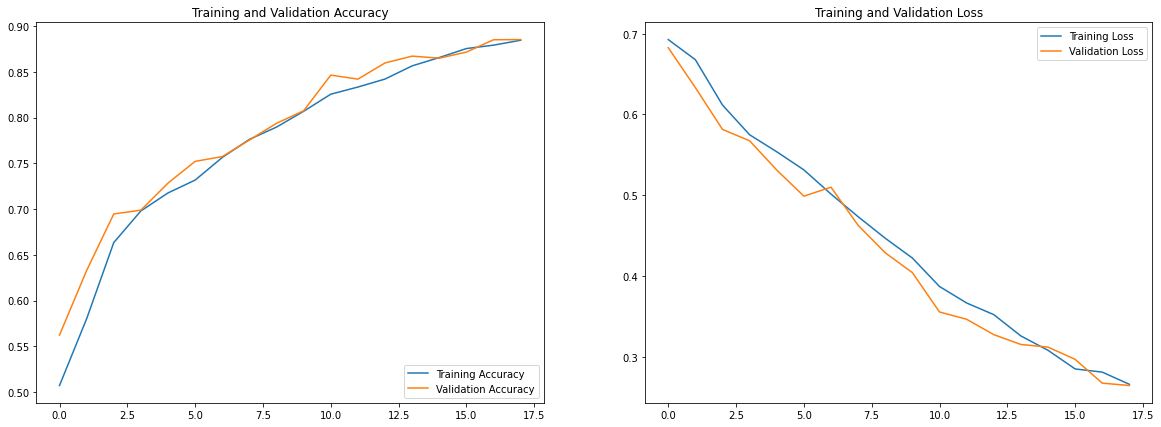

time: 551 ms (started: 2022-12-03 21:14:15 +00:00)


In [55]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(18)

plt.figure(figsize=(20, 7))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig("model_150x150.pdf")
files.download("model_150x150.pdf") 

In [56]:
model.evaluate(train_ds)

128/128 [==============================] - 7s 52ms/step - loss: 0.2266 - binary_accuracy: 0.9047


[0.22658441960811615, 0.904718279838562]

time: 6.68 s (started: 2022-12-03 21:14:29 +00:00)


In [57]:
model.evaluate(val_ds)

39/39 [==============================] - 2s 52ms/step - loss: 0.2650 - binary_accuracy: 0.8852


[0.26502174139022827, 0.8851799964904785]

time: 2.07 s (started: 2022-12-03 21:14:38 +00:00)


In [58]:
model.evaluate(test_ds)

16/16 [==============================] - 6s 246ms/step - loss: 0.2857 - binary_accuracy: 0.8784


[0.28574833273887634, 0.87841796875]

time: 6.12 s (started: 2022-12-03 21:14:40 +00:00)


Using model on my pictures 150x150

In [59]:
%%capture
!unzip gdrive/My\ Drive/Machine\ Learning\ Project/CatDog_real.zip
my_data = pathlib.Path("/content/CatDog_real") 
real_test= tf.keras.utils.image_dataset_from_directory(
  my_data,
    color_mode="rgb",
  validation_split=None,
  image_size=(img_height, img_width),
 #batch_size=batch_size
 )

time: 2.53 s (started: 2022-12-03 21:14:56 +00:00)


In [61]:
model.evaluate(real_test)

1/1 [==============================] - 1s 653ms/step - loss: 0.2821 - binary_accuracy: 0.9500


[0.2821018099784851, 0.949999988079071]

time: 669 ms (started: 2022-12-03 21:15:29 +00:00)


1/1 [==============================] - 0s 19ms/step


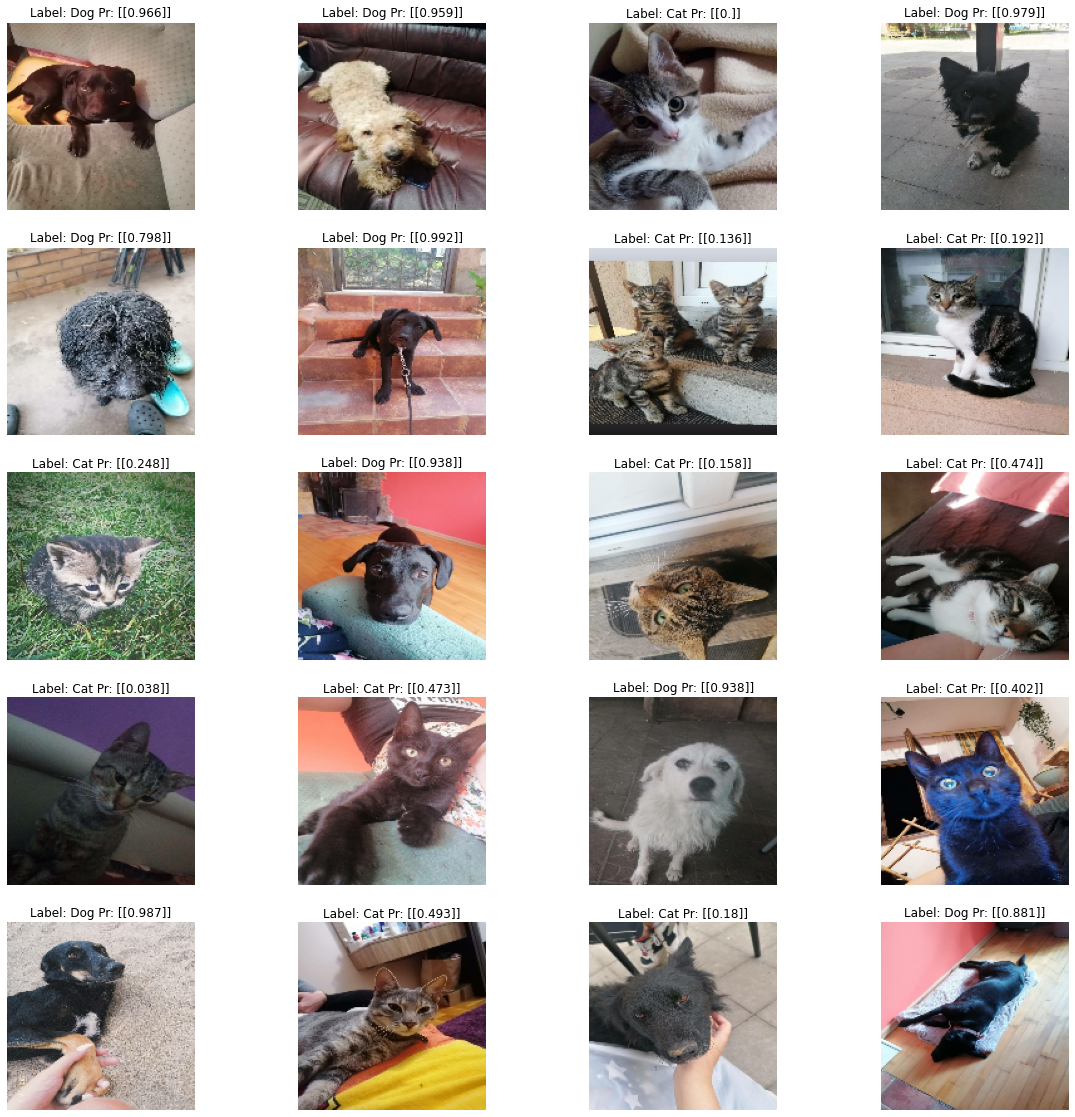

time: 3.82 s (started: 2022-12-03 21:15:01 +00:00)


In [60]:
class_names=["Cat","Dog"]
image ,label = next(iter(real_test))
fig, axes = plt.subplots(5,4,figsize=(20,20))
for idx, axe in enumerate(axes.flatten()):
    axe.axis('off')
    y_pred=model.predict(image[idx][None,...])
    axe.imshow(image[idx].numpy().astype("uint8"))
    axe.set_title(f'Label: {class_names[np.where((y_pred)<0.5,0,1).flat[0]]} Pr: {y_pred.round(3)}')

### Full model once more 256x256 resolution (just increased resolution)

In [8]:
batch_size = 128
img_height = 256
img_width = 256 

time: 673 µs (started: 2022-12-03 21:41:50 +00:00)


In [9]:
train_ds= tf.keras.utils.image_dataset_from_directory(
  data_dir,
    color_mode="rgb",
  validation_split=0.3,
  subset="training",
  shuffle=True,
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 23404 files belonging to 2 classes.
Using 16383 files for training.
time: 2.32 s (started: 2022-12-03 21:41:51 +00:00)


In [10]:
val_ds= tf.keras.utils.image_dataset_from_directory(
  data_dir,
    color_mode="rgb",
  validation_split=0.3,
  subset="validation",
  seed=seed,#123
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 23404 files belonging to 2 classes.
Using 7021 files for validation.
time: 808 ms (started: 2022-12-03 21:41:53 +00:00)


In [11]:
test_ds = val_ds.take(round(len(val_ds)*0.3))
val_ds = val_ds.skip(round(len(val_ds)*0.3))

time: 3.69 ms (started: 2022-12-03 21:41:54 +00:00)


In [12]:
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.RandomRotation((-0.20, 0.20),seed=1), #vrati 20 
    tf.keras.layers.RandomZoom((-0.30,0.30),seed=1), #30
  ]
)

time: 18.3 ms (started: 2022-12-03 21:41:55 +00:00)


In [ ]:
#AUTOTUNE = tf.data.AUTOTUNE
# for 256x256 we can't cache in RAM
#train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
#test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [13]:
model_256 = tf.keras.Sequential([
        data_augmentation,
        tf.keras.layers.Rescaling(1./255, input_shape=(img_height, img_width,3)),

        tf.keras.layers.Conv2D(32, (3, 3), strides = 1,padding="same", activation='relu',kernel_initializer=tf.keras.initializers.glorot_uniform(seed=1)),
        #tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(pool_size=(2,2)),


        #Second convolutional layer followed by max pooling
        tf.keras.layers.Conv2D(64, (3, 3), strides = 1,padding="same", activation='relu',kernel_initializer=tf.keras.initializers.glorot_uniform(seed=1)),
        #tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(pool_size=(2,2)),

        #Third convolutional layer followed by max pooling
        tf.keras.layers.Conv2D(64, (3, 3), strides = 1,padding="same", activation='relu',kernel_initializer=tf.keras.initializers.glorot_uniform(seed=1)),
        #tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(pool_size=(2,2)),


        #Fourth convolutional layer followed by max pooling
        tf.keras.layers.Conv2D(128, (3, 3), strides = 1,padding="same", activation='relu',kernel_initializer=tf.keras.initializers.glorot_uniform(seed=1)),
        #tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(pool_size=(2,2)),


        #Fifth convolutional layer followed by max pooling
        tf.keras.layers.Conv2D(128, (3, 3), strides = 1,padding="same", activation='relu',kernel_initializer=tf.keras.initializers.glorot_uniform(seed=1)),
        #tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(pool_size=(2,2)),

            
        #Neural Network
        tf.keras.layers.Flatten(),  
        tf.keras.layers.Dense(128, activation="relu",kernel_initializer=tf.keras.initializers.glorot_uniform(seed=1)),
        tf.keras.layers.Dropout(0.1,seed=1),
        tf.keras.layers.Dense(128, activation="relu",kernel_initializer=tf.keras.initializers.glorot_uniform(seed=1)),
        tf.keras.layers.Dropout(0.1,seed=1),
        tf.keras.layers.Dense(128, activation="relu",kernel_initializer=tf.keras.initializers.glorot_uniform(seed=1)),
        tf.keras.layers.Dropout(0.1,seed=1),
        tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer=tf.keras.initializers.glorot_uniform(seed=1)), 
        ])
        
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0008)
metric = tf.keras.metrics.BinaryAccuracy()
loss_function = tf.keras.losses.BinaryCrossentropy()
model_256.compile(optimizer=optimizer, loss=loss_function, metrics=metric)

time: 35.8 ms (started: 2022-12-03 21:42:23 +00:00)


In [14]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3,mode='min') #model when using 256x256 size images
# This callback will stop the training when there is no improvement in
# the val_loss for three consecutive epochs.
epochs = 21
history_256=model_256.fit(
  train_ds, #train_ds
  validation_data=val_ds, #val_ds
  epochs=epochs,
    verbose=1,
    callbacks=[callback]
)

Epoch 1/21
128/128 [==============================] - 72s 501ms/step - loss: 0.6734 - binary_accuracy: 0.5614 - val_loss: 0.6207 - val_binary_accuracy: 0.6602
Epoch 2/21
128/128 [==============================] - 65s 484ms/step - loss: 0.5914 - binary_accuracy: 0.6811 - val_loss: 0.6669 - val_binary_accuracy: 0.7108
Epoch 3/21
128/128 [==============================] - 61s 460ms/step - loss: 0.5604 - binary_accuracy: 0.7112 - val_loss: 0.5262 - val_binary_accuracy: 0.7370
Epoch 4/21
128/128 [==============================] - 60s 457ms/step - loss: 0.5320 - binary_accuracy: 0.7319 - val_loss: 0.5340 - val_binary_accuracy: 0.7221
Epoch 5/21
128/128 [==============================] - 61s 464ms/step - loss: 0.4948 - binary_accuracy: 0.7567 - val_loss: 0.4576 - val_binary_accuracy: 0.7776
Epoch 6/21
128/128 [==============================] - 60s 458ms/step - loss: 0.4487 - binary_accuracy: 0.7873 - val_loss: 0.4358 - val_binary_accuracy: 0.8102
Epoch 7/21
128/128 [==========================

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

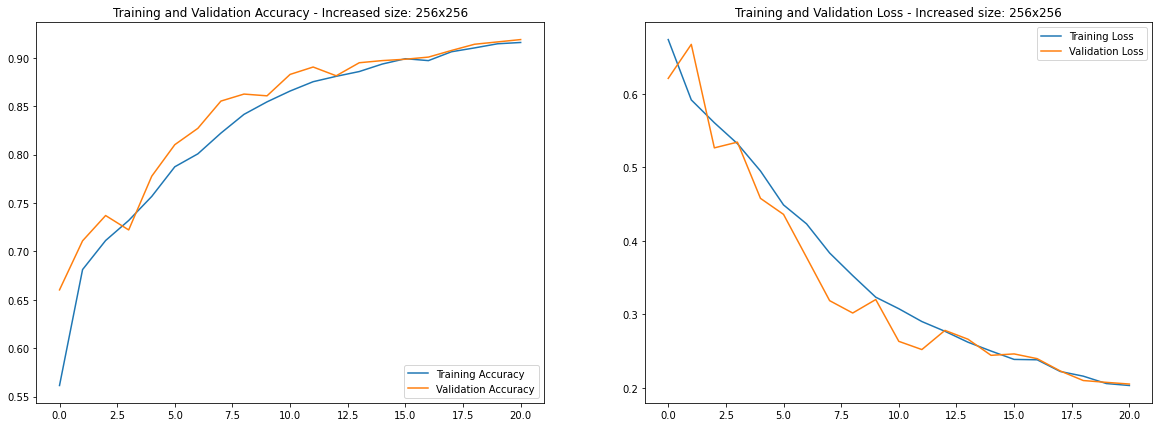

time: 647 ms (started: 2022-12-03 22:05:48 +00:00)


In [15]:
acc = history_256.history['binary_accuracy']
val_acc = history_256.history['val_binary_accuracy']

loss = history_256.history['loss']
val_loss = history_256.history['val_loss']

epochs_range = range(21)

plt.figure(figsize=(20, 7))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy - Increased size: 256x256')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss - Increased size: 256x256')
plt.savefig("model_256x256.pdf")
files.download("model_256x256.pdf") 

In [17]:
model_256.evaluate(train_ds)#256x256

128/128 [==============================] - 36s 264ms/step - loss: 0.1574 - binary_accuracy: 0.9360


[0.15743952989578247, 0.9359701871871948]

time: 35.8 s (started: 2022-12-03 22:06:26 +00:00)


In [18]:
model_256.evaluate(val_ds) #256x256

39/39 [==============================] - 12s 205ms/step - loss: 0.2036 - binary_accuracy: 0.9190


[0.20361608266830444, 0.9189624190330505]

time: 12.5 s (started: 2022-12-03 22:07:19 +00:00)


In [19]:
model_256.evaluate(test_ds) #256x256

16/16 [==============================] - 6s 289ms/step - loss: 0.2186 - binary_accuracy: 0.9131


[0.21860438585281372, 0.9130859375]

time: 6.07 s (started: 2022-12-03 22:07:39 +00:00)


Using model on my pictures 256x256

In [20]:
%%capture
!unzip gdrive/My\ Drive/Machine\ Learning\ Project/CatDog_real.zip
my_data = pathlib.Path("/content/CatDog_real") 
real_test= tf.keras.utils.image_dataset_from_directory(
  my_data,
    color_mode="rgb",
  validation_split=None,
  image_size=(img_height, img_width),
 #batch_size=batch_size
 )

time: 3.02 s (started: 2022-12-03 22:07:51 +00:00)


In [21]:
model_256.evaluate(real_test)

1/1 [==============================] - 1s 539ms/step - loss: 0.1966 - binary_accuracy: 0.9500


[0.19660189747810364, 0.949999988079071]

time: 553 ms (started: 2022-12-03 22:07:59 +00:00)


1/1 [==============================] - 0s 21ms/step


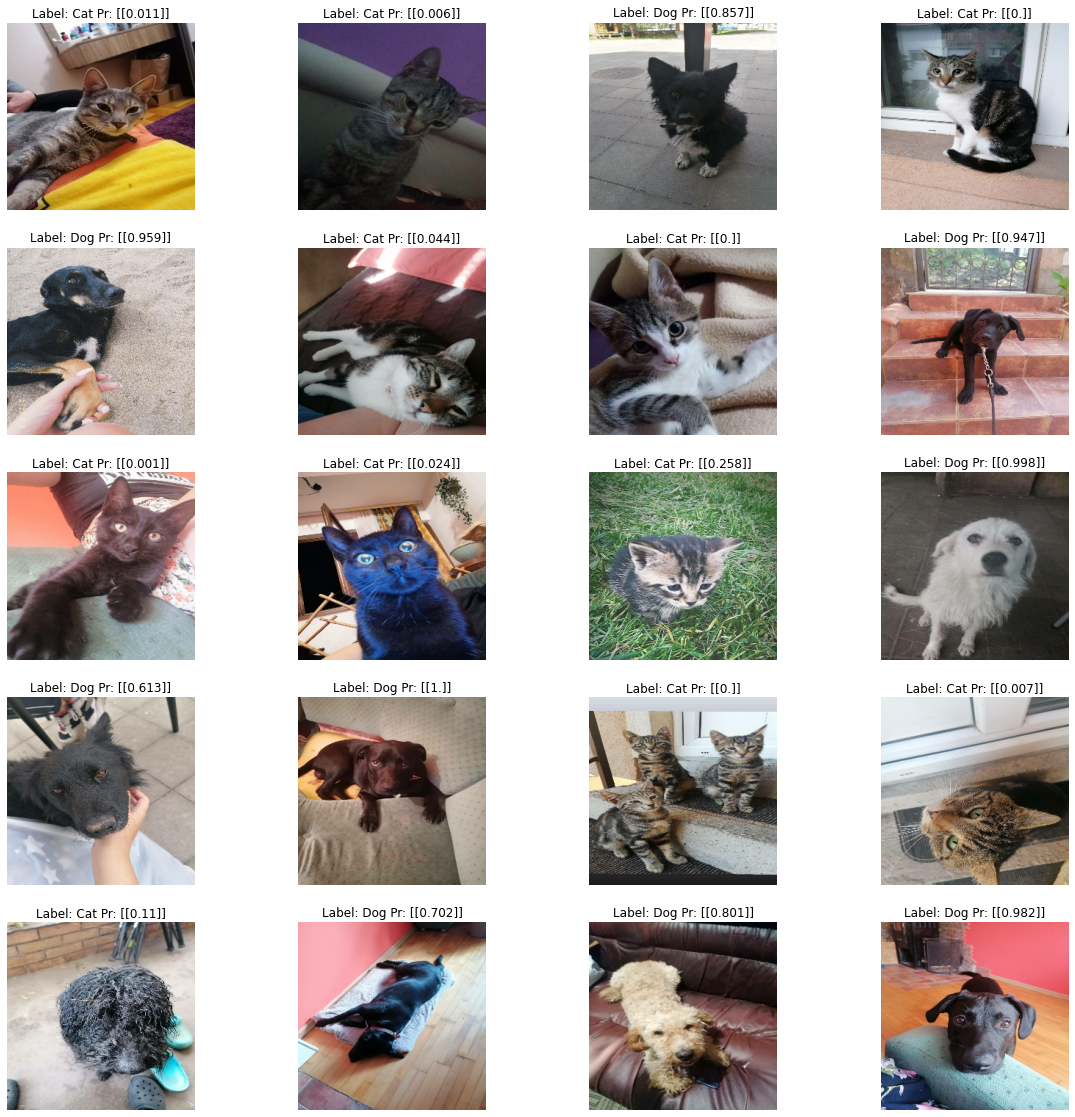

time: 3.67 s (started: 2022-12-03 22:08:24 +00:00)


In [22]:
class_names=["Cat","Dog"]
image ,label = next(iter(real_test))
fig, axes = plt.subplots(5,4,figsize=(20,20))
for idx, axe in enumerate(axes.flatten()):
    axe.axis('off')
    y_pred=model_256.predict(image[idx][None,...])
    axe.imshow(image[idx].numpy().astype("uint8"))
    axe.set_title(f'Label: {class_names[np.where((y_pred)<0.5,0,1).flat[0]]} Pr: {y_pred.round(3)}')